In [81]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pprint

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPRegressor

In [254]:
# Tic tac toe
WINNING_COMBINATIONS = [
    # horizontal
    set([0, 1, 2]),
    set([3, 4, 5]),
    set([6, 7, 8]),
    # vertical
    set([0, 3, 6]),
    set([1, 4, 7]),
    set([2, 5, 8]),
    # diagonal
    set([0, 4, 8]),
    set([2, 4, 6])
]

def init_state():
    return np.array([0]*9)

def get_display_value(element):
    if element == 0:
        return " "
    elif element == 1:
        return "o"
    elif element == -1:
        return "x"

def display_board(state, blank_line_at_end=False):
    for i in range(3):
        elements = state[(3*i):(3*i+3)]
        print "|".join([get_display_value(element) for element in elements])
    if blank_line_at_end:
        print ""

def random_action(state, is_player_move):
    empty_elements = np.where(state == 0)[0]
    if len(empty_elements) > 0:
        position = np.random.choice(empty_elements)
        new_state = state.copy()
        new_state[position] = 1 if is_player_move else -1
        return new_state, position, True
    else:
        print "AAAAAAAAAAAAAA"
        return new_state, 0, False

def game_state(state, is_player_move):
    player_piece = 1 if is_player_move else -1
    piece_positions = set(np.where(state == player_piece)[0])
    for combination in WINNING_COMBINATIONS:
        if combination.issubset(piece_positions):
            return False, True, False # still_going, player_has_won, is_draw
    empty_elements = np.where(state == 0)[0]
    if len(empty_elements) > 0:
        return True, False, False
    return False, False, True

def player_next_move(state, qval):
    new_state = state.copy()
    actions = np.argsort(qval)
    actions_argsort = np.argsort(actions)
    did_something = False
    z = 0
    while not did_something:
        if state[actions[actions_argsort[z]]] == 0:
            action = actions[actions_argsort[z]]
            new_state[action] = 1
            did_something = True
            return new_state, action, did_something
        z += 1
            
def player_move_and_win_check(state, player_is_random):
    # Player move
    if player_is_random:
        new_state, action, did_something = random_action(state, True)
    else:
        qval = model.predict(state.reshape(-1, 1))
        new_state, action, did_something = player_next_move(state, qval)
    
    still_going, player_has_won, is_draw = game_state(new_state, True)
    # Draw/Win check
    if is_draw:
        # Draw
        games.append(0)
        if player_is_random:
            random_games.append(0)
        else:
            chosen_games.append(0)
        return new_state, action, False, 0
    elif player_has_won:
        # Player win
        games.append(1)
        if player_is_random:
            random_games.append(1)
        else:
            chosen_games.append(1)
        return new_state, action, False, 1
    else:
        return new_state, action, True, 0

def adversary_move_and_win_check(state, player_is_random):
    new_state, action, did_something = random_action(state, False)
    still_going, player_has_won, is_draw = game_state(new_state, False)
    
    if is_draw:
        # Draw
        games.append(0)
        if player_is_random:
            random_games.append(0)
        else:
            chosen_games.append(0)
        return new_state, action, False, 0
    elif player_has_won:
        # Adversary wins
        games.append(-1)
        if player_is_random:
            random_games.append(-1)
        else:
            chosen_games.append(-1)
        return new_state, action, False, -1
    else:
        return new_state, action, True, 0

def add_to_plays_description(player_is_random, player_first, reward, nb_rounds):
    play_type = 'random_play' if player_is_random else 'chosen_play'
    player_sequence = 'player_first' if player_first else 'player_second'
    play_outcome = 'win' if reward > 0 else 'loss' if reward < 0 else 'draw'
    plays_description[play_type][player_sequence][play_outcome] += 1
    plays_description[play_type][player_sequence]['#rounds'] += nb_rounds

In [255]:
state = init_state()
for i in range(9):
    is_player_move = i % 2 == 0
    new_state, action, did_something = random_action(state, is_player_move)
    still_going, player_has_won, is_draw = game_state(new_state, is_player_move)
    
    if is_draw:
        display_board(new_state)
        print "DRAW"
        break
    elif player_has_won:
        display_board(new_state)
        print "WINNER"
        break
    state = new_state

o|o|o
 |x|x
 |x|o
WINNER


In [269]:
# Initializing model with a first mini-batch
model = MLPRegressor(
    learning_rate='constant' # invscaling
)

X_init = init_state().reshape(-1, 1)
y_init = init_state()

model = model.partial_fit(X_init, y_init)

X_init.shape, np.array(y_init).shape

((9, 1), (9,))

In [270]:
model.predict(init_state().reshape(-1, 1))

array([ 0.00016864,  0.00016864,  0.00016864,  0.00016864,  0.00016864,
        0.00016864,  0.00016864,  0.00016864,  0.00016864])

In [ ]:
nb_epochs = 1000
logging_rate = int(nb_epochs/10) if int(nb_epochs/10) > 0 else 1
random_plays = 0
chosen_plays = 0
epsilon = 0.5
games = []
random_games = []
chosen_games = []
update_stages = defaultdict(int)
plays_description = {
    'random_play':{
        'player_first':{
            'win': 0,
            'loss': 0,
            'draw': 0,
            '#rounds': 0
        },
        'player_second':{
            'win': 0,
            'loss': 0,
            'draw': 0,
            '#rounds': 0
        }
    },
    'chosen_play':{
        'player_first':{
            'win': 0,
            'loss': 0,
            'draw': 0,
            '#rounds': 0
        },
        'player_second':{
            'win': 0,
            'loss': 0,
            'draw': 0,
            '#rounds': 0
        }
    }
}
    

for i in range(nb_epochs):
    
    # Initializing the game
    state = init_state()
    tmp_states = []
    still_going = True
    reward = 0
    update = 0
    player_is_random = random.random() < epsilon
    player_first = np.random.choice([True, False])
    if player_is_random:
        random_plays += 1
    else:
        chosen_plays += 1
    
    if i % logging_rate == 0:
        print ">>>>>> "+str(i)
#         print ">>>>>> "+str(i)+" | random: "+str(player_is_random)+" | first: "+str(player_first)
        
    # Playing
    while still_going:
        
        if player_first:
            # Player move and win check
            middle_state, action, still_going, reward = player_move_and_win_check(state, player_is_random)
            
            # Continue if no win
            if still_going:
                # Adversary move and win check
                new_state, adversary_action, still_going, reward = adversary_move_and_win_check(middle_state, player_is_random)
            else:
                new_state = middle_state
            considered_state = state
        else:
            # Adversary move and win check
            middle_state, adversary_action, still_going, reward = adversary_move_and_win_check(state, player_is_random)
            
            # Continue if no win
            if still_going:
                # Adversary move and win check
                new_state, action, still_going, reward = player_move_and_win_check(middle_state, player_is_random)
            else:
                new_state = middle_state
            
            considered_state = middle_state
        
        # Machine learning
        tmp_states.append([considered_state.copy(), action.copy()])
        if not still_going:
#             display_board(new_state)
#             print 'WINNER' if reward > 0 else 'LOSER' if reward < 0 else 'DRAW'
            add_to_plays_description(player_is_random, player_first, reward, len(tmp_states))
            
            for tmp_state, tmp_action in tmp_states:
                y = np.zeros(9)
                y[tmp_action] = reward #/ float(len(tmp_states))
                model.partial_fit(tmp_state.reshape(-1, 1), y)
        
        state = new_state

# Statistical descriptions
print "==========================================="
games_np = np.array(games)
print "wins: "+str(np.sum(games_np == 1))+" | losses: "+str(np.sum(games_np == -1))+" | draws: "+str(np.sum(games_np == 0))
print "random plays: "+str(random_plays)+" | chosen plays: "+str(chosen_plays)
pprint.PrettyPrinter(indent=4).pprint(plays_description)

>>>>>> 0
>>>>>> 100
>>>>>> 200
>>>>>> 300


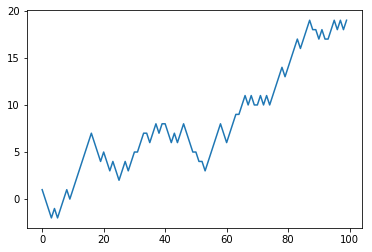

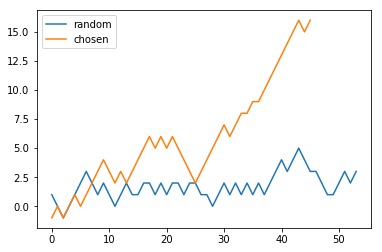

In [266]:
plt.figure(1)
plt.plot(np.cumsum(games))

plt.figure(2)
plt.plot(np.cumsum(random_games), label="random")
plt.plot(np.cumsum(chosen_games), label="chosen")
plt.legend(loc=0)

plt.show()

In [267]:
board_example = np.array([1, -1, 0, 1, -1, 0, 0, 0, 0])
display_board(board_example, blank_line_at_end=True)

# One move
qval = model.predict(board_example.reshape(-1, 1))
new_state, action, did_something = player_next_move(board_example, qval)

display_board(new_state, blank_line_at_end=True)

o|x| 
o|x| 
 | | 

o|x|o
o|x| 
 | | 



In [268]:
board_example = init_state()
display_board(board_example, blank_line_at_end=True)

# One move
qval = model.predict(board_example.reshape(-1, 1))
new_state, action, did_something = player_next_move(board_example, qval)

display_board(new_state, blank_line_at_end=True)

 | | 
 | | 
 | | 

o| | 
 | | 
 | | 



In [ ]:
for tmp_state, tmp_action in tmp_states:
    y = np.zeros(9)
    y[tmp_action] = reward #/ float(len(tmp_states))
    print tmp_state.reshape(-1, 1)
    print y
    